# **Geez Number Recognizer**

## **Step 1 - Import necessary Libraries.**

In [2]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
from glob import glob
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from PIL import Image
import cv2

## **Step 2 - Load Dataset**

In [4]:

def load_dataset_to_df(data_dir):
    image_paths = []
    labels = []

    for label_folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label_folder)

        # Ensure it's a directory and label is a number
        if os.path.isdir(folder_path) and label_folder.isdigit():
            label = int(label_folder)

            for file in os.listdir(folder_path):
                if file.lower().endswith('.png'):
                    full_path = os.path.join(folder_path, file)
                    image_paths.append(full_path)
                    labels.append(label)

    df = pd.DataFrame({'image': image_paths, 'label': labels})
    return df

# Update this path to your real dataset path
data_dir = r"C:\Users\Hp\Documents\Eyob\Geez OCR\geez_number_dataset"

df = load_dataset_to_df(data_dir)
print(df.head(10))  # Should show different labels like 1, 2, 3...



                                               image  label
0  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
1  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
2  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
3  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
4  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
5  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
6  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
7  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
8  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1
9  C:\Users\Hp\Documents\Eyob\Geez OCR\geez_numbe...      1


### **Helps to see the number of images in each class**

In [5]:
print(df['label'].value_counts().sort_index())


label
1     36
2     36
3     36
4     36
5     36
      ..
95    36
96    36
97    36
98    36
99    36
Name: count, Length: 99, dtype: int64


### **Visualization of loaded images from Dataset**

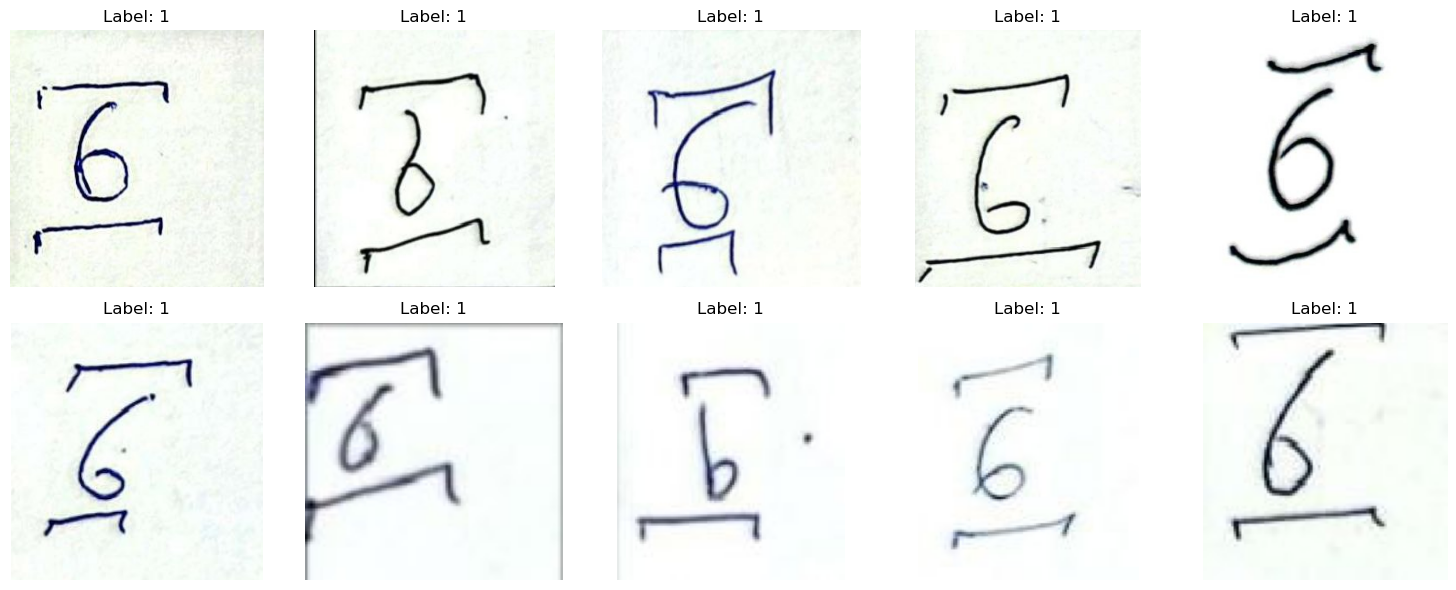

In [6]:

def plot_multiple_samples(df, num_samples=10):
    plt.figure(figsize=(15, 6))
    
    for i in range(num_samples):
        row = df.iloc[i]
        img = cv2.imread(row['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Label: {row['label']}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the first 10 images
plot_multiple_samples(df, num_samples=10)



## **Step 3 - Pre-processing**

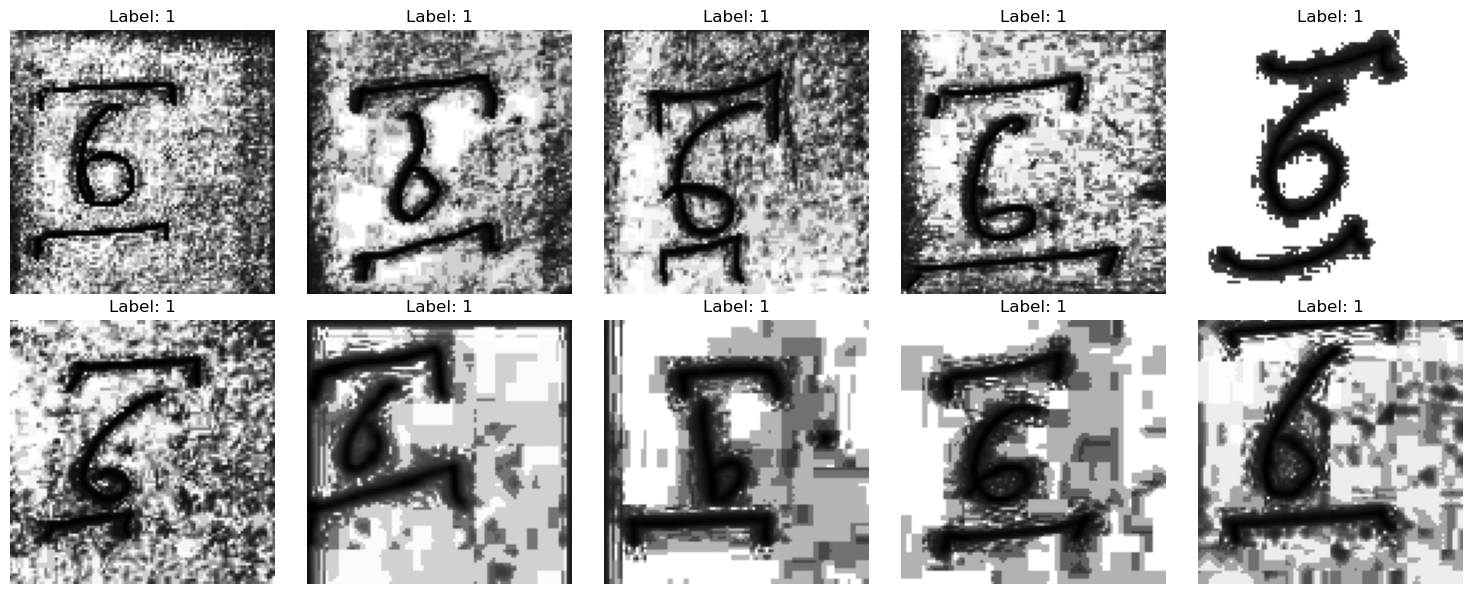

In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def preprocess_image(img, size=(100, 100), to_gray=True, normalize=True, hist_eq=False):
    # Resize
    img_resized = cv2.resize(img, size)
    
    # Grayscale conversion
    if to_gray:
        img_processed = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    else:
        img_processed = img_resized
    
    # Histogram Equalization (only for grayscale)
    if hist_eq and to_gray:
        img_processed = cv2.equalizeHist(img_processed)
    
    # Normalize to 0-1 float
    if normalize:
        img_processed = img_processed.astype(np.float32) / 255.0
    
    return img_processed

def plot_multiple_samples_preprocessed(df, num_samples=10):
    plt.figure(figsize=(15, 6))
    
    for i in range(num_samples):
        row = df.iloc[i]
        img = cv2.imread(row['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_processed = preprocess_image(img, size=(100, 100), to_gray=True, normalize=True, hist_eq=True)
        
        plt.subplot(2, 5, i+1)
        # For grayscale images normalized, matplotlib handles float images well
        plt.imshow(img_processed, cmap='gray')
        plt.title(f"Label: {row['label']}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run this to plot first 10 preprocessed images
plot_multiple_samples_preprocessed(df, num_samples=10)



## **Step 4 - Prepare Data for Modeling**

### Convert Images and Labels into Arrays

In [8]:
import numpy as np

def load_and_preprocess(df, size=(100, 100), to_gray=True):
    images = []
    labels = []
    
    for i in range(len(df)):
        row = df.iloc[i]
        img = cv2.imread(row['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Preprocess the image (resize, grayscale, normalize, hist equalization)
        img_processed = preprocess_image(img, size=size, to_gray=to_gray, normalize=True, hist_eq=True)
        
        # For grayscale, add channel dimension
        if to_gray:
            img_processed = img_processed[..., np.newaxis]
        
        images.append(img_processed)
        labels.append(row['label'])
    
    X = np.array(images)  # image data as numpy array
    y = np.array(labels)  # labels as numpy array
    
    return X, y

# Example usage:
X, y = load_and_preprocess(df, size=(100, 100), to_gray=True)
print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Images shape: (3563, 100, 100, 1)
Labels shape: (3563,)


### Encode Labels

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Encoded labels example:", y_encoded[:10])


Encoded labels example: [0 0 0 0 0 0 0 0 0 0]


### Split Dataset into Train and Test Sets

In [10]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Train set size: 2850
Test set size: 713


## **Step 5 - Build, Train, and Evaluate a CNN with TensorFlow/Keras**

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # For multi-class classification
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Parameters
input_shape = X_train.shape[1:]  # (100, 100, 1)
num_classes = len(label_encoder.classes_)

# Create model
model = create_cnn_model(input_shape, num_classes)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 389ms/step - accuracy: 0.0053 - loss: 4.6024 - val_accuracy: 0.0035 - val_loss: 4.5962
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 386ms/step - accuracy: 0.0110 - loss: 4.5948 - val_accuracy: 0.0140 - val_loss: 4.5952
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 339ms/step - accuracy: 0.0250 - loss: 4.4856 - val_accuracy: 0.0474 - val_loss: 4.2487
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 386ms/step - accuracy: 0.0553 - loss: 4.1371 - val_accuracy: 0.0877 - val_loss: 3.9218
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 373ms/step - accuracy: 0.0877 - loss: 3.7658 - val_accuracy: 0.1649 - val_loss: 3.3642
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - accuracy: 0.1605 - loss: 3.2816 - val_accuracy: 0.2421 - val_loss: 2.7861
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.2132 - loss: 2.8862 - val_accuracy: 0.3474 - val_loss: 2.3198
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.2873 - loss: 2.5064 - val_accu

### **Visualize Training Progress**

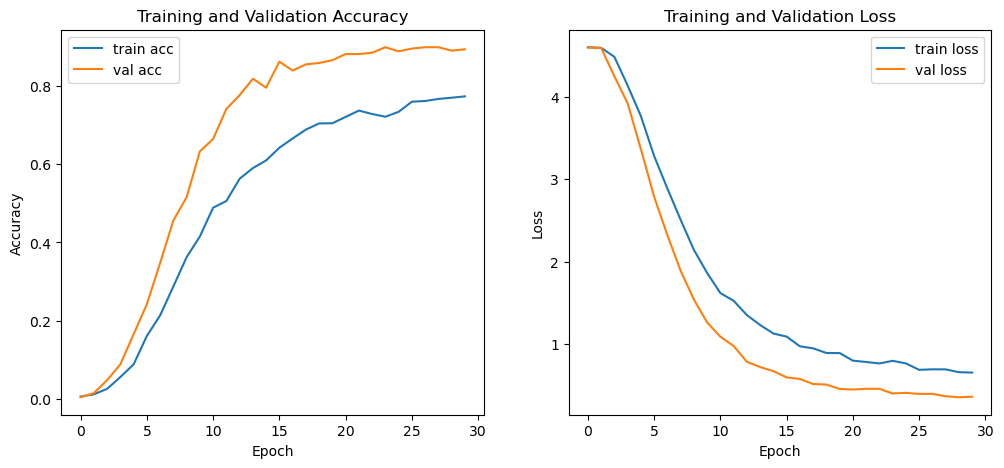

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Simple summary of what the plots show:

✅ **Accuracy**: Both training and validation accuracy steadily increase, reaching around 77–90% by the last epochs. The validation accuracy is slightly higher than training, which happen with small datasets.

✅ **Loss**: Both training and validation loss decrease over epochs, stabilizing near low values, showing the model is learning and fitting the data.

✅ **Overall**: The model is learning effectively, with no severe overfitting, and training seems stable. Accuracy is improving steadily and loss decreases consistently.

# **The End for now!!!**